# ` GPN Intelligence Cup 2020: Data Science`

# &1. Анализ исходных данных 

In [1]:
import pandas as pd
import numpy as np

## 1.1. Анализ данных по продажам

In [2]:
sales = pd.read_parquet('sales.parquet')
sales.head(5) # посмотрим на общий вид данных, в каждом из магазинов может продаваться несколько типов продукции

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0


In [3]:
sales.info() # размер df, типы данных df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5081459 entries, 0 to 5081458
Data columns (total 6 columns):
date                  datetime64[ns]
shop_id               int64
owner                 object
number_of_counters    int32
goods_type            object
total_items_sold      float64
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(2)
memory usage: 213.2+ MB


In [4]:
sales.isna().values.any() # отлично, пропусков в данных по продажам нет

False

In [5]:
sales['owner'].value_counts() # все возможные владельцы магазинов, 5 видов

Рейдеры                       3906481
Воины полураспада              595022
Стервятники                    275076
Последователи Апокалипсиса     169120
Бомбисты                       135760
Name: owner, dtype: int64

In [6]:
sales['goods_type'].value_counts() # все возможные типы товаров

Бензак                615722
Солярка               585314
Съедобный хлам        551292
Хлам                  540485
Патроны               505188
Броня и одежда        493856
Ядер-Кола             474912
Медпрепараты и еда    413378
Модификации тачки     353090
Жидкости для тачки    320589
Оружие                227633
Name: goods_type, dtype: int64

In [7]:
sales['total_items_sold'].value_counts()[-1] # total_items_sold содержит отрицательные значения!

10

In [8]:
len(set(sales['shop_id'])) # количество уникальных id магазинов

845

## 1.2. Анализ данных по характеристикам магазинов

In [9]:
shops = pd.read_parquet('shops.parquet') 
shops.head(5) # замечен первый None

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [10]:
shops.info() # размер df и типы данных
# количество строк в shops совпадает с количеством уникальных id, значит информация по характеристикам магазинов уникальна, данные есть по каждому магазину 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 8 columns):
shop_id                        845 non-null int32
neighborhood                   845 non-null object
city                           788 non-null object
year_opened                    845 non-null int32
is_on_the_road                 838 non-null object
is_with_the_well               785 non-null object
is_with_additional_services    784 non-null object
shop_type                      713 non-null object
dtypes: int32(2), object(6)
memory usage: 46.3+ KB


In [11]:
shops.isna().values.any() # подтверждение присутствия пропусков в данных 

True

In [12]:
for i in shops.columns:
    print(i, shops[i].isna().values.any()) # пропуски в колонках city, is_on_the_road, is_with_the_well, is_with_additional_services, shop_type 

shop_id False
neighborhood False
city True
year_opened False
is_on_the_road True
is_with_the_well True
is_with_additional_services True
shop_type True


In [13]:
shops['year_opened'].value_counts()[:2] # в значениях года присутствуют отрицательные значения (год открытия неизвестен)!

 2139    94
-1       63
Name: year_opened, dtype: int64

In [14]:
shops['shop_type'].value_counts() # все возможные типы магазинов

1    385
2    150
3    115
4     63
Name: shop_type, dtype: int64

In [15]:
shops['neighborhood'].value_counts() # все возможные значения neighborhood

В центре     309
У тоннеля    169
На отшибе    115
У ночлега     81
У воды        77
Промзона      62
С краю        32
Name: neighborhood, dtype: int64

## 1.3. Анализ данных о разбивке городов по локациям

In [16]:
cities = pd.read_parquet('cities.parquet')
cities.head(5)

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь


In [17]:
cities.info() # размер df и тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
city        15 non-null object
location    15 non-null object
dtypes: object(2)
memory usage: 368.0+ bytes


# &2. Отбор информативных признаков

In [18]:
from sklearn import preprocessing

## 2.1 Формирование признаков по типам продаваемой продукции

* Из таблицы sales видно, что в каждом из магазинов может продаваться несколько видов товара. Возможно, разные магазины специализируются на разных видах товаров, поэтому вклад признака __"вид товара"__, несомненно,  __будет влиять на результат итоговой кластеризации магазинов__
* Разбиение кластеров по типам продукции интуитивно логично. Например, в магазинах, специализирующихся на "Съедобном хламе", можно проводить одни промокампании и выстраивать определенные макркетинговые стратегии, а в магазинах, специализирующихся на "Солярке", будут использоваться совершеннно другие стратегии

In [19]:
# группирую данные, так, что каждому id соответствует уникальный тип товара и сумма всех проданных товаров данного типа товара
shop_info = sales.groupby(['shop_id','goods_type'], as_index=False).aggregate({'total_items_sold' : 'sum'})
shop_info.head(10) # полученная группировка

,shop_id,goods_type,total_items_sold
0,0,Бензак,11647666.0
1,0,Броня и одежда,81.0
2,0,Жидкости для тачки,35.0
3,0,Съедобный хлам,1077.0
4,0,Хлам,1351.0
5,1,Бензак,9079168.0
6,1,Броня и одежда,1236.0
7,1,Жидкости для тачки,298.0
8,1,Солярка,1548661.0
9,1,Съедобный хлам,20340.0


In [20]:
goods = set(shop_info['goods_type']) # получаю множество уникалных типов товаров
ids = set(shop_info['shop_id']) # получаю множество уникальных shop id  
X = pd.DataFrame({"shop_id":pd.Series(list(ids))}) # создаю колонку со списком shop_id, чтобы потом добавлять к ней сформированные признаки признаки

In [21]:
# поочередно создаю колонки вида shop_id - количество проданного товара определенного типа и добавляю их к X
for type_i in goods:
    feature = sales[sales['goods_type'] == type_i].groupby('shop_id').aggregate({'total_items_sold' : 'sum'})
    feature = feature.rename(columns={'total_items_sold': type_i})
    X = pd.merge(left=X, right=feature, left_on='shop_id', right_on='shop_id',  how='outer')

In [23]:
# таким образом, X содержит информацию о количестве проданного товара определенного типа по каждому shop_id
X.head(10) 

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,Модификации тачки,Оружие
0,0,11647666.0,1351.0,81.0,NaN,35.0,NaN,NaN,NaN,1077.0,NaN,NaN
1,1,9079168.0,5321.0,1236.0,NaN,298.0,NaN,1548661.0,NaN,20340.0,NaN,NaN
2,2,7953184.0,39997.0,21571.0,3109.0,3550.0,636472.0,1378414.0,47141.0,115414.0,5527.0,2526.0
3,3,23048831.0,17724.0,754.0,NaN,13286.0,NaN,2399400.0,5.0,32051.0,61.0,30.0
4,4,23389524.0,79956.0,13826.0,37541.0,15438.0,797282.0,3258548.0,161995.0,289664.0,16925.0,844.0
5,5,21835937.0,86394.0,38255.0,48769.0,12466.0,860789.0,2451011.0,237754.0,284567.0,17291.0,8778.0
6,6,11627584.0,18157.0,1378.0,NaN,4980.0,NaN,3223573.0,12318.0,70612.0,211.0,NaN
7,7,11104626.0,39762.0,3843.0,111.0,2539.0,102628.0,921224.0,29458.0,44845.0,1675.0,476.0
8,8,4228536.0,62788.0,4444.0,10689.0,12815.0,215113.0,997187.0,165528.0,237388.0,6542.0,535.0
9,9,9175262.0,59839.0,468.0,NaN,12806.0,NaN,5883914.0,44894.0,80611.0,543.0,77.0


### Требуется обработка полученных данных:
* данные содержат nan 
* необходима нормализация признаков: значения ячеек слишком большие, удобнее рассматривать долю каждого из типов товаров в сумме общих продаж магазина, а не количество проданного товара

In [24]:
X = X.fillna(0)# заполняем nan нулями
df = X.drop(columns=['shop_id']) # убираем shop_id, нормализация данного признака не требуется 
normalized_X =pd.DataFrame(preprocessing.normalize(df), columns = df.columns) # нормализация
data1 = pd.concat([X["shop_id"], normalized_X], axis=1)
data1.head(10)

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,Модификации тачки,Оружие
0,0,1.000000,0.000116,0.000007,0.000000,0.000003,0.000000,0.000000,0.000000e+00,0.000092,0.000000,0.000000
1,1,0.985760,0.000578,0.000134,0.000000,0.000032,0.000000,0.168144,0.000000e+00,0.002208,0.000000,0.000000
2,2,0.982130,0.004939,0.002664,0.000384,0.000438,0.078597,0.170219,5.821388e-03,0.014252,0.000683,0.000312
3,3,0.994624,0.000765,0.000033,0.000000,0.000573,0.000000,0.103541,2.157645e-07,0.001383,0.000003,0.000001
4,4,0.989765,0.003383,0.000585,0.001589,0.000653,0.033738,0.137891,6.855079e-03,0.012258,0.000716,0.000036
5,5,0.992844,0.003928,0.001739,0.002217,0.000567,0.039139,0.111443,1.081028e-02,0.012939,0.000786,0.000399
6,6,0.963634,0.001505,0.000114,0.000000,0.000413,0.000000,0.267153,1.020853e-03,0.005852,0.000017,0.000000
7,7,0.996516,0.003568,0.000345,0.000010,0.000228,0.009210,0.082670,2.643527e-03,0.004024,0.000150,0.000043
8,8,0.969858,0.014401,0.001019,0.002452,0.002939,0.049338,0.228715,3.796553e-02,0.054447,0.001500,0.000123
9,9,0.841738,0.005490,0.000043,0.000000,0.001175,0.000000,0.539790,4.118575e-03,0.007395,0.000050,0.000007


## 2.2 Формирование признаков по характеристикам магазинов 

* Добавим ещё некоторые наборы признаков из данных по характеристикам магазинов. Такие признаки как neighborhood, is_on_the_road, is_with_additional_services, shop_type - носят ограмный информативный характер
* __Почему эти признаки важны?__ В реальной жизни в магазин у дома люди чаще заходят за продуктами для приготовления ужина, в магазин около бизнес-центра зайдут скорее за обедом или фруктами. Возможно, и в нашем случае в магазине "В центе" и в магазине "На отшибе" спрос на товары может сильно отличаться, поэтому признаки __neighborhood, is_on_the_road, shop_type__  могут потенциально внести огромный вклад в итоговою кластеризацию
* __is_with_additional_services__ - весомый бинарный признак. Представим ситуацию: у нас есть два типа АЗС. В АЗС первого типа на территории есть минимаркет, в АЗС другого типа соответственно минимаркета нет. Понятно, что прогнозировать спрос для этих двух типов АЗС нужно по-разному, более того, в данном случае будут использоваться разные стратегии управления и маркетинга, будут планироваться разные промокампании 


In [25]:
shops.head(5)# заметим, что shop_id не отсортированы 

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [26]:
shops = shops.sort_values('shop_id') # отсортируем shop_id, чтобы впоследствие было удобнее конкатенировать признаки
shops.head(5)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
259,0,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None
770,1,В центре,Нефтеперегонный Завод,2115,нет,нет,нет,None
592,2,Промзона,Нефтеперегонный Завод,2115,нет,нет,да,2
701,3,У ночлега,Нефтеперегонный Завод,2092,нет,нет,нет,3
628,4,В центре,Нефтеперегонный Завод,2108,нет,нет,да,1


Как было замечено в пункте 1.2 строки is_on_the_road, is_with_the_well, is_with_additional_services, shop_type содержат nan, более того, эти строки имеют тип object

In [27]:
shops = shops.replace('да', 1) # преобразуем категориальные признаки в числовые
shops = shops.replace('нет', 0) # преобразуем категориальные признаки в числовые
shops[['is_on_the_road', 'is_with_the_well', 'is_with_additional_services']] = shops[['is_on_the_road', 'is_with_the_well', 'is_with_additional_services']].fillna(0)
shops['shop_type'] = shops['shop_type'].fillna('1') # заменяем None на медианное значение shop_type (т.к значения shop_type имеют тип object)

In [28]:
# преобразуем категориальный признак neighborhood с помощью dummy-кодирования в набор бинарных признаков
(pd.get_dummies(shops["neighborhood"])).head(5)

,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
259,1,0,0,0,0,0,0
770,1,0,0,0,0,0,0
592,0,0,1,0,0,0,0
701,0,0,0,0,0,1,0
628,1,0,0,0,0,0,0


In [29]:
# добавим полученные признаки к признакам из пункта 2.1
neigh_id = pd.concat([shops['shop_id'], pd.get_dummies(shops["neighborhood"])], axis=1) 
data2 = pd.merge(left=data1, right=neigh_id, left_on='shop_id', right_on='shop_id',  how='outer')
data2.head(5)

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,Модификации тачки,Оружие,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
0,0,1.000000,0.000116,0.000007,0.000000,0.000003,0.000000,0.000000,0.000000e+00,0.000092,0.000000,0.000000,1,0,0,0,0,0,0
1,1,0.985760,0.000578,0.000134,0.000000,0.000032,0.000000,0.168144,0.000000e+00,0.002208,0.000000,0.000000,1,0,0,0,0,0,0
2,2,0.982130,0.004939,0.002664,0.000384,0.000438,0.078597,0.170219,5.821388e-03,0.014252,0.000683,0.000312,0,0,1,0,0,0,0
3,3,0.994624,0.000765,0.000033,0.000000,0.000573,0.000000,0.103541,2.157645e-07,0.001383,0.000003,0.000001,0,0,0,0,0,1,0
4,4,0.989765,0.003383,0.000585,0.001589,0.000653,0.033738,0.137891,6.855079e-03,0.012258,0.000716,0.000036,1,0,0,0,0,0,0


* Признак __shop_type__ в данном случае является категориальнм (числовые значения лишь кодируют тип), поэтому необходимо также использовать dummy-кодирование для обработки данного признака

In [30]:
type_id = pd.concat([shops['shop_id'], pd.get_dummies(shops["shop_type"])], axis=1) 
data3 = pd.merge(left=data2, right=type_id, left_on='shop_id', right_on='shop_id',  how='outer')
# переименуем столбцы с типом для более удобной работы
for i in range(1, 5):
    data3 = data3.rename(columns={f'{i}': f'shop_type_{i}'})
data3.head(5)

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,...,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0,1.000000,0.000116,0.000007,0.000000,0.000003,0.000000,0.000000,0.000000e+00,0.000092,...,0,0,0,0,0,0,1,0,0,0
1,1,0.985760,0.000578,0.000134,0.000000,0.000032,0.000000,0.168144,0.000000e+00,0.002208,...,0,0,0,0,0,0,1,0,0,0
2,2,0.982130,0.004939,0.002664,0.000384,0.000438,0.078597,0.170219,5.821388e-03,0.014252,...,0,1,0,0,0,0,0,1,0,0
3,3,0.994624,0.000765,0.000033,0.000000,0.000573,0.000000,0.103541,2.157645e-07,0.001383,...,0,0,0,0,1,0,0,0,1,0
4,4,0.989765,0.003383,0.000585,0.001589,0.000653,0.033738,0.137891,6.855079e-03,0.012258,...,0,0,0,0,0,0,1,0,0,0


* добавим признаки is_on_the_road, is_with_the_well, is_with_additional_service к уже сформированным признакам

In [31]:
data4 = pd.merge(left=data3, right=shops[['shop_id','is_on_the_road', 'is_with_the_well', 'is_with_additional_services']], left_on='shop_id', right_on='shop_id',  how='outer')
data4.head(5)

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,...,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,is_on_the_road,is_with_the_well,is_with_additional_services
0,0,1.000000,0.000116,0.000007,0.000000,0.000003,0.000000,0.000000,0.000000e+00,0.000092,...,0,0,0,1,0,0,0,0.0,0.0,0.0
1,1,0.985760,0.000578,0.000134,0.000000,0.000032,0.000000,0.168144,0.000000e+00,0.002208,...,0,0,0,1,0,0,0,0.0,0.0,0.0
2,2,0.982130,0.004939,0.002664,0.000384,0.000438,0.078597,0.170219,5.821388e-03,0.014252,...,0,0,0,0,1,0,0,0.0,0.0,1.0
3,3,0.994624,0.000765,0.000033,0.000000,0.000573,0.000000,0.103541,2.157645e-07,0.001383,...,0,1,0,0,0,1,0,0.0,0.0,0.0
4,4,0.989765,0.003383,0.000585,0.001589,0.000653,0.033738,0.137891,6.855079e-03,0.012258,...,0,0,0,1,0,0,0,0.0,0.0,1.0


## 2.3 Формирование гипотетически информативных признаков

* Возможно, такие признаки как __year__ - год основания магазина и __city__ - локация магазина __способны улучшить итоговую кластеризацию__ 
* Вполне логично, что новые магазины привлекают больше посетителей, соответственно спрос в таких магазинах может быть выше. Но это лишь предположение, которое будет проверено на практике при построении кластеров
* Каждый регион имеет свои особенности и свою сезонность: например в Сибири и на Дальнем Востоке заморозки начинаются с первой половины осени, а значит спрос, например, на дизельное топливо упадет раньше, чем в Санкт-Петербурге и Ленинградской области. Данный признак также гипотетически может внести вклад в итоговую клвстеризацию
* Проверки требует и признак __owner__ из характеристик по продажам. Возможно, от владельца группы магазинов и от реализуемой стратегии зависит уровень продаж товаров в данных магазинах. Проверим, как полияет этот признак на итоговую клвстеризацию

Нормализуем значения признака "year" и добавим его к уже сформированным признакам: 

In [32]:
year = shops["year_opened"]
mean_value = round(shops[year!= -1]["year_opened"].mean())
year = year.replace(-1, mean_value) # заменяем -1 на медианное значение столбца year
year = (year-year.min())/(year.max()-year.min()) # нормализация данных
year_id = pd.concat([shops['shop_id'], year], axis=1) 
data5 = pd.merge(left=data4, right=year_id, left_on='shop_id', right_on='shop_id',  how='outer') # формируем набор с признаками
data5.head(5)

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,...,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,is_on_the_road,is_with_the_well,is_with_additional_services,year_opened
0,0,1.000000,0.000116,0.000007,0.000000,0.000003,0.000000,0.000000,0.000000e+00,0.000092,...,0,0,1,0,0,0,0.0,0.0,0.0,0.898551
1,1,0.985760,0.000578,0.000134,0.000000,0.000032,0.000000,0.168144,0.000000e+00,0.002208,...,0,0,1,0,0,0,0.0,0.0,0.0,0.594203
2,2,0.982130,0.004939,0.002664,0.000384,0.000438,0.078597,0.170219,5.821388e-03,0.014252,...,0,0,0,1,0,0,0.0,0.0,1.0,0.594203
3,3,0.994624,0.000765,0.000033,0.000000,0.000573,0.000000,0.103541,2.157645e-07,0.001383,...,1,0,0,0,1,0,0.0,0.0,0.0,0.260870
4,4,0.989765,0.003383,0.000585,0.001589,0.000653,0.033738,0.137891,6.855079e-03,0.012258,...,0,0,1,0,0,0,0.0,0.0,1.0,0.492754


Заменим пропуски и обработаем признак city с помощью dummy-кодированния:

In [33]:
city_id = pd.concat([shops['shop_id'], pd.get_dummies(shops['city'])], axis=1) 
city_id = city_id.fillna(0)
data5 = pd.merge(left=data5, right=city_id, left_on='shop_id', right_on='shop_id',  how='outer')
data5.head(5)

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,...,Лагерь,Нефтеперегонный Завод,Пасть,Равнина Маяка,Свинцовая Ферма,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель
0,0,1.000000,0.000116,0.000007,0.000000,0.000003,0.000000,0.000000,0.000000e+00,0.000092,...,0,1,0,0,0,0,0,0,0,0
1,1,0.985760,0.000578,0.000134,0.000000,0.000032,0.000000,0.168144,0.000000e+00,0.002208,...,0,1,0,0,0,0,0,0,0,0
2,2,0.982130,0.004939,0.002664,0.000384,0.000438,0.078597,0.170219,5.821388e-03,0.014252,...,0,1,0,0,0,0,0,0,0,0
3,3,0.994624,0.000765,0.000033,0.000000,0.000573,0.000000,0.103541,2.157645e-07,0.001383,...,0,1,0,0,0,0,0,0,0,0
4,4,0.989765,0.003383,0.000585,0.001589,0.000653,0.033738,0.137891,6.855079e-03,0.012258,...,0,1,0,0,0,0,0,0,0,0


In [34]:
data5.isna().values.any() # убедились, что в признаках нет nan

False

Сформируем признак owner и добавим его к признакам:

In [35]:
shop_owners = sales.groupby(['shop_id','owner'],as_index=False).aggregate({'total_items_sold': 'sum'})
print(shop_owners.shape) # у некоторых shop id менялись owners, поэтому строк больше, чем уникальных shop_id
shop_owners.head(5)

(1002, 3)


,shop_id,owner,total_items_sold
0,0,Рейдеры,11650210.0
1,1,Рейдеры,10655024.0
2,2,Рейдеры,10206905.0
3,3,Рейдеры,25512142.0
4,4,Рейдеры,28061543.0


In [36]:
shop_owners = shop_owners.drop_duplicates(subset ="shop_id") # удалим дубликаты shop id, чтобы учитывать только текущих владельцев
print(shop_owners.shape) # 845 - как раз столько, сколько имеется уникальных shop id
shop_owners.head(5)

(845, 3)


,shop_id,owner,total_items_sold
0,0,Рейдеры,11650210.0
1,1,Рейдеры,10655024.0
2,2,Рейдеры,10206905.0
3,3,Рейдеры,25512142.0
4,4,Рейдеры,28061543.0


In [37]:
owners_dummy = pd.get_dummies(shop_owners["owner"]) # обработка признака
id_owners = pd.concat([shop_owners['shop_id'], owners_dummy], axis=1)
data6 = pd.merge(left=data5, right=id_owners, left_on='shop_id', right_on='shop_id', how = 'outer')
data6.head(5)

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,...,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель,Бомбисты,Воины полураспада,Последователи Апокалипсиса,Рейдеры,Стервятники
0,0,1.000000,0.000116,0.000007,0.000000,0.000003,0.000000,0.000000,0.000000e+00,0.000092,...,0,0,0,0,0,0,0,0,1,0
1,1,0.985760,0.000578,0.000134,0.000000,0.000032,0.000000,0.168144,0.000000e+00,0.002208,...,0,0,0,0,0,0,0,0,1,0
2,2,0.982130,0.004939,0.002664,0.000384,0.000438,0.078597,0.170219,5.821388e-03,0.014252,...,0,0,0,0,0,0,0,0,1,0
3,3,0.994624,0.000765,0.000033,0.000000,0.000573,0.000000,0.103541,2.157645e-07,0.001383,...,0,0,0,0,0,0,0,0,1,0
4,4,0.989765,0.003383,0.000585,0.001589,0.000653,0.033738,0.137891,6.855079e-03,0.012258,...,0,0,0,0,0,0,0,0,1,0


### `Таким образом, были получены 6 тестовых наборов с признаками:`

* __data1__: признаки по типам продаваемой продукции, профили продаж
* __data2__: data1 + признаки по окрестности магазина (neighborhood)
* __data3__: data2 + признаки по типу магазина (shop type)¶
* __data4__: data3 + признаки is_on_the_road, is_with_the_well, is_with_additiona
* __data5__: data4 + признаки year, city
* __data6__: data5 + признак owner

## 2.4 Оценка  тенденции кластеризации

Прежде чем строить кластеризацию, важно убедиться, что набор данных (признаков),имеет тенденцию кластеризации и не содержит равномерно распределенных точек. Ведь если данные не содержат тенденцию кластеризации, то построенные кластеры не возможно будет интерпретировать и они не будут значимыми. Для этого используется критерий Хопкинса, если H > 0.5, то вероятно, данные содержат кластеры

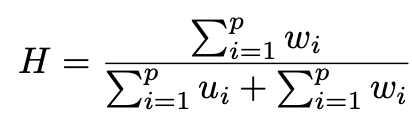

In [38]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

In [39]:
def hopkins(X):
    d = X.shape[1]
    n = len(X) 
    m = int(0.1 * n) 
    ujd, wjd  = [], []
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
    rand_X = sample(range(0, n, 1), m)
 
    for j in range(m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
    
    return sum(ujd) / (sum(ujd) + sum(wjd))

In [40]:
hopkins(data6.drop(columns='shop_id')) # чем ближе значение критерия к 1, тем больше тенденция классификации 

0.8506891355965268

Таким образом, построенное признаковое описание объектов обладает тенденцией кластеризации, а значит можно переходить к кластрезации объектов.

# & 3. Выбор метрик качества кластеризации

Прежде чем проводить кластеризацию, необходимо определить метрики качества, которые будут использоваться для проверки качества кластеризации.

### 1) среднее внутрикластерное расстояние

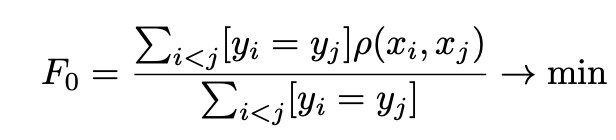

### 2) среднее межкластерное расстояние

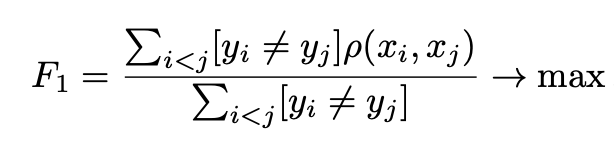

### 3) комбинация функционалов

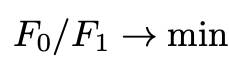

Но так или иначе эти функционалы имеют ряд недостатков. Например, с помощью таких функционалов нельзя подобрать количество кластеров. Действительно, при использовании таких метрик лучшим вариантом будет отнести каждую точку к своему собственному кластеру, так как в этом случае среднее внутрикластерное расстояние будет равно нулю.

### 4) Коэффициент силуэта 

Коэффициент силуэта — метрика качества, которая позволяет выбрать количество кластеров, выбирается число кластеров, максимизирующее значение силуэта. Коэффициент силуэта определяется по формуле:

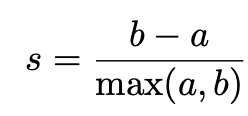

где a — среднее расстояние от данного объекта до других объектов из того же кластера, b — среднее расстояние от данного объекта до объектов из ближайшего другого кластера

  Данная величина лежит в диапазоне [−1,1]. Значения, близкие к -1, соответствуют разрозненным кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным", четко выделенным кластерам. Таким образом, __чем больше силуэт, тем более четко выделены кластеры__, и они представляют собой компактные, плотно сгруппированные облака точек

__Так как число кластеров в решаемой задаче нам заранее неизвестно, то логично использовать коэффициент силуэта в том числе и для выбора оптимального количества кластеров__

# & 4. Реализация алгоритмов кластеризации и проверка качества

Проводить первичную кластеризацию будем на всех собранных признаках: data6 (47 признаков)

In [41]:
data6.head(10)

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,...,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель,Бомбисты,Воины полураспада,Последователи Апокалипсиса,Рейдеры,Стервятники
0,0,1.000000,0.000116,0.000007,0.000000,0.000003,0.000000,0.000000,0.000000e+00,0.000092,...,0,0,0,0,0,0,0,0,1,0
1,1,0.985760,0.000578,0.000134,0.000000,0.000032,0.000000,0.168144,0.000000e+00,0.002208,...,0,0,0,0,0,0,0,0,1,0
2,2,0.982130,0.004939,0.002664,0.000384,0.000438,0.078597,0.170219,5.821388e-03,0.014252,...,0,0,0,0,0,0,0,0,1,0
3,3,0.994624,0.000765,0.000033,0.000000,0.000573,0.000000,0.103541,2.157645e-07,0.001383,...,0,0,0,0,0,0,0,0,1,0
4,4,0.989765,0.003383,0.000585,0.001589,0.000653,0.033738,0.137891,6.855079e-03,0.012258,...,0,0,0,0,0,0,0,0,1,0
5,5,0.992844,0.003928,0.001739,0.002217,0.000567,0.039139,0.111443,1.081028e-02,0.012939,...,0,0,0,0,0,0,0,0,1,0
6,6,0.963634,0.001505,0.000114,0.000000,0.000413,0.000000,0.267153,1.020853e-03,0.005852,...,0,0,0,0,0,0,1,0,0,0
7,7,0.996516,0.003568,0.000345,0.000010,0.000228,0.009210,0.082670,2.643527e-03,0.004024,...,0,0,0,0,0,0,0,0,1,0
8,8,0.969858,0.014401,0.001019,0.002452,0.002939,0.049338,0.228715,3.796553e-02,0.054447,...,0,0,0,0,0,0,0,0,1,0
9,9,0.841738,0.005490,0.000043,0.000000,0.001175,0.000000,0.539790,4.118575e-03,0.007395,...,0,0,0,0,0,0,0,0,1,0


## 4.1. DBSCAN

Для начала применим алгоритм __DBSCAN, основанный на плотности точек__ в окрестности каждого объекта выборки. Согласно данному алгоритму, все точки делятся на __основные, пограничные и шумовые__. Далее, соединяются основные точки, находящиеся на расстоянии eps друг от друга, в результате получается граф. Каждая группа __основных точек объединяется в свой кластер__ (выделяются связные компоненты в получившемся графе). Пограничные точки относятся к соответствующим им кластерам

In [42]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [43]:
shop_id = data6['shop_id']
X = data6.drop(columns=['shop_id']) # уберем из признаков метки объектов, их не нужно включать в кластеризацию

In [44]:
def dbscan_alg(X_np, eps=1.4, min_samples=5):
    """
    Input: X_np - признаковое описание объектов; 
            eps - эпсилон окрестность точек, которые будут объединяться в кластер;
            min_samples - число объектов в окрестности точки, которая будет считаться основной.
    Output: algo_labels - метки кластеров;
            s - значение коэффициента силуэта
    """
    dbscan = DBSCAN(eps, min_samples)
    dbscan.fit(X_np)
    algo_labels = dbscan.labels_
    s = metrics.silhouette_score(X_np, algo_labels)
    
    return algo_labels, s

# параметры eps и min_samples подбирались эмпирическим образом конкретно для поставленной задачи

In [45]:
labels, s = dbscan_alg(X.to_numpy())# получаем метки классов и значение силуэта
print(f" Получено {max(labels)} кластеров","\n",f"Коэффициент силуэта:{s}") 

 Получено 30 кластеров 
 Коэффициент силуэта:0.09109019704318885


C таким набором признаков __коэффициент силуэта невелик__, это говорит о том, что построенные кластеры пересекаются/ накладываются друг на друга. Возможно, мы выделили слишком много признаков и не все они являются информативными. Проверим информативность каждого из признаков по построенной кластеризации.

### Проверка информативности признаков по построенной кластеризации

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

In [47]:
def X_importance(X_df, labels):
    """
    Input: X_df - признаковое описание объектов; 
           labels - метки кластеров, полученные в результате кластеризации
    Output: диаграмма информативности признаков
    """
    n = X_df.shape[1]
    model = ExtraTreesClassifier()
    model.fit(X_df, labels)

    fig = plt.figure(figsize=(15,10))
    feat_importances = pd.Series(model.feature_importances_, index=X_df.columns)
    feat_importances.nlargest(n).plot(kind='barh')
#     features = feat_importances.nlargest(n) если захотим вывести информативность каждого признака
    plt.show()

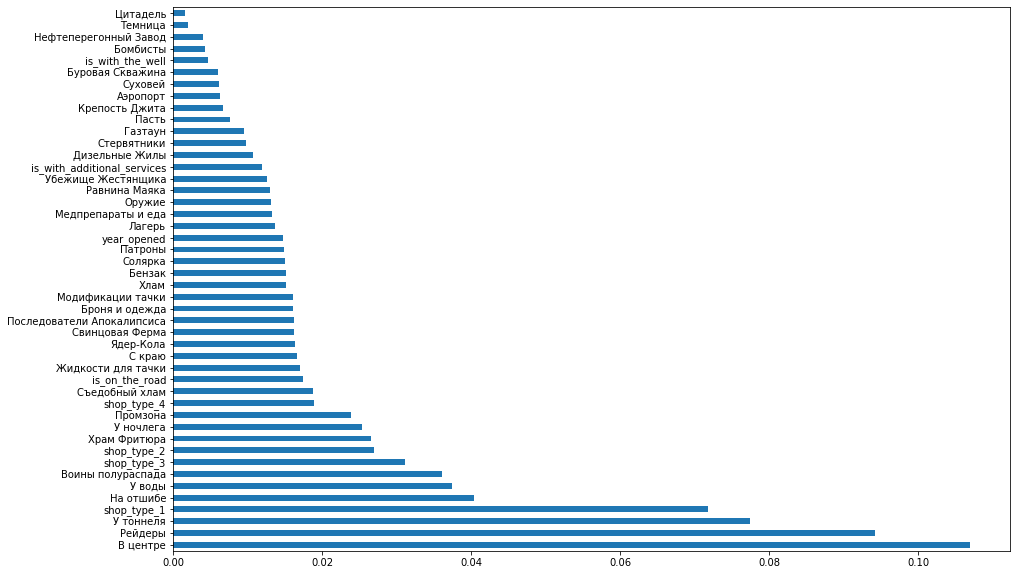

In [48]:
X_importance(X, labels)

Таким образом, __из данной диаграммы были выделены основные информативные признаки__, эти признаки совпадают с набором признаков data3, полученным на этапе 2. Далее для проведения кластеризации будут использоваться признаки data3.

In [49]:
data3.head(5)

,shop_id,Бензак,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,...,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0,1.000000,0.000116,0.000007,0.000000,0.000003,0.000000,0.000000,0.000000e+00,0.000092,...,0,0,0,0,0,0,1,0,0,0
1,1,0.985760,0.000578,0.000134,0.000000,0.000032,0.000000,0.168144,0.000000e+00,0.002208,...,0,0,0,0,0,0,1,0,0,0
2,2,0.982130,0.004939,0.002664,0.000384,0.000438,0.078597,0.170219,5.821388e-03,0.014252,...,0,1,0,0,0,0,0,1,0,0
3,3,0.994624,0.000765,0.000033,0.000000,0.000573,0.000000,0.103541,2.157645e-07,0.001383,...,0,0,0,0,1,0,0,0,1,0
4,4,0.989765,0.003383,0.000585,0.001589,0.000653,0.033738,0.137891,6.855079e-03,0.012258,...,0,0,0,0,0,0,1,0,0,0


In [50]:
shop_id = data3['shop_id']
X_1 = data3.drop(columns=['shop_id']) # уберем из признаков метки объектов, их не нужно включать в кластеризацию

In [51]:
labels1, s1 = dbscan_alg(X_1.to_numpy())# получаем метки классов и значение силуэта
print(f" Получено {max(labels1)} кластеров","\n",f"Коэффициент силуэта:{s1}") 

 Получено 23 кластеров 
 Коэффициент силуэта:0.8914130382919782


Видно, что __значение коэффициента силуэта значительно улучшилось__ и стало близким к 1, значит кластеры стали "плотными" и четко выделенным. __Количество сформированных кластеров при этом уменьшилось__.

Оценим информативность признаков в данном случае:

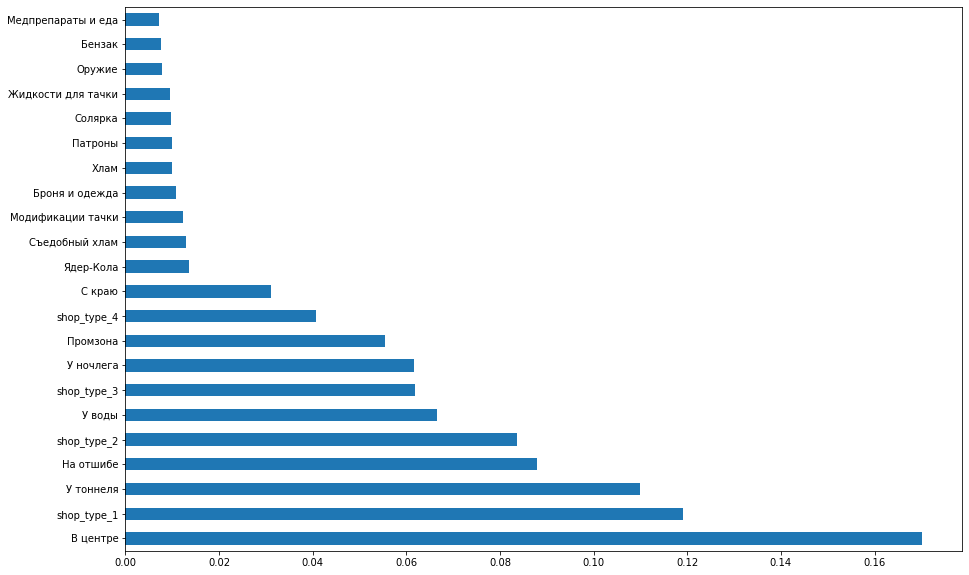

In [53]:
X_importance(X_1, labels1)

Проанализируем признаки X_1 с точки зрения их взаимосвязи, построим корреляционную матрицу.

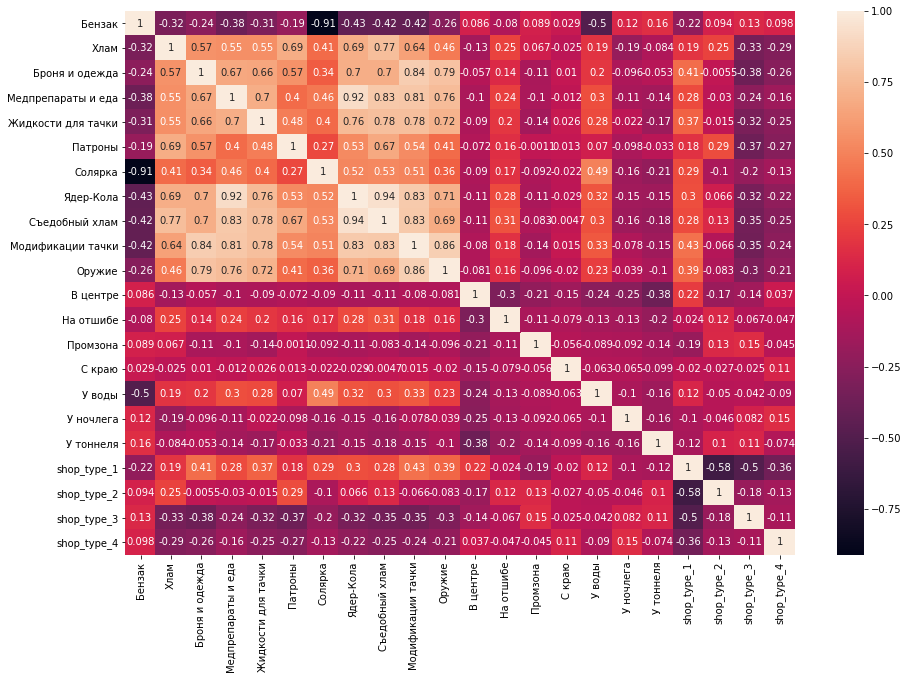

In [54]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(X_1.corr(), annot = True)

Из построенной диаграммы иформативности признаков и матрицы корреляции видно, что признак __"Бензак" имеет низкую информативность__. Более того, данный признак __отрицательно коррелирован__ (линейно зависим) с некоторыми другими признаками, что может плохо сказываться на кластеризации.

In [55]:
X_1['Бензак'].mean() # среднее значение данного признака по всем объектам

0.9584228158508071

In [56]:
X_1['Бензак'].head(5) 

0    1.000000
1    0.985760
2    0.982130
3    0.994624
4    0.989765
Name: Бензак, dtype: float64

Признак __"Бензак" имеет малую информативность__, так как значения данного признака для всех объектов примерно одинаковы и довольно большие (в доле общих продаж магазинов), что видно из среднего значения признака по всем объектам. 

Уберем из рассмотрения признак "Бензак" и проверим качество кластеризации в данном случае:

In [57]:
X_2 = X_1.drop(columns=['Бензак'])
labels2, s2 = dbscan_alg(X_2.to_numpy()) # получаем метки классов и значение силуэта
print(f" Получено {max(labels2)} кластеров","\n",f"Коэффициент силуэта:{s2}") 

 Получено 23 кластеров 
 Коэффициент силуэта:0.8971874756287045


Таким образом, коэффициент силуэта стал ещё ближе к 1, а значит кластеры стали более плотными.

## Определение оптимального количества кластеров

С помощью алгоритма DBSCAN мы выявили, что при заданной окрестности и числе соседей кластеров может быть __23, однако оптимально ли данное количество кластеров?__ DBSCAN хорошо справляется с нетривиальными формами кластеров и успешно отделяет шумовые точки, которые могли бы сильно испортить работу других алгоритмов кластеризации. __Но DBSCAN часто неправильно определяет количество кластеров, особенно когда несколько кластеров расположены слишком близко друг к другу__.

Для более точного определения количества кластеров можно использовать понятный и простой метод __агломеративной иерархической кластеризации__. 

## 4.2 Агломеративная иерархическая кластеризация

__Иерархическая кластеризация__ — кластеризация, в которой кластеры получаются вложенными друг в друга. __Агломеративный подход__: каждый объект помещается в свой собственный кластер, которые постепенно объединяются. В начале работы алгоритма все объекты являются отдельными кластерами. Затем вычисляется расстояние между кластерами
по выбранному методу (__single__ - минимальное межкластерное расстояние, __complete__ - максимальное межкластерное расстояние, __average__ - невзвешенное попарное среднее). Наиболее похожие, близкие объекты объединяются в кластер. На последующих шагах объединение продолжается до тех пор, пока все объекты не будут составлять один кластер.

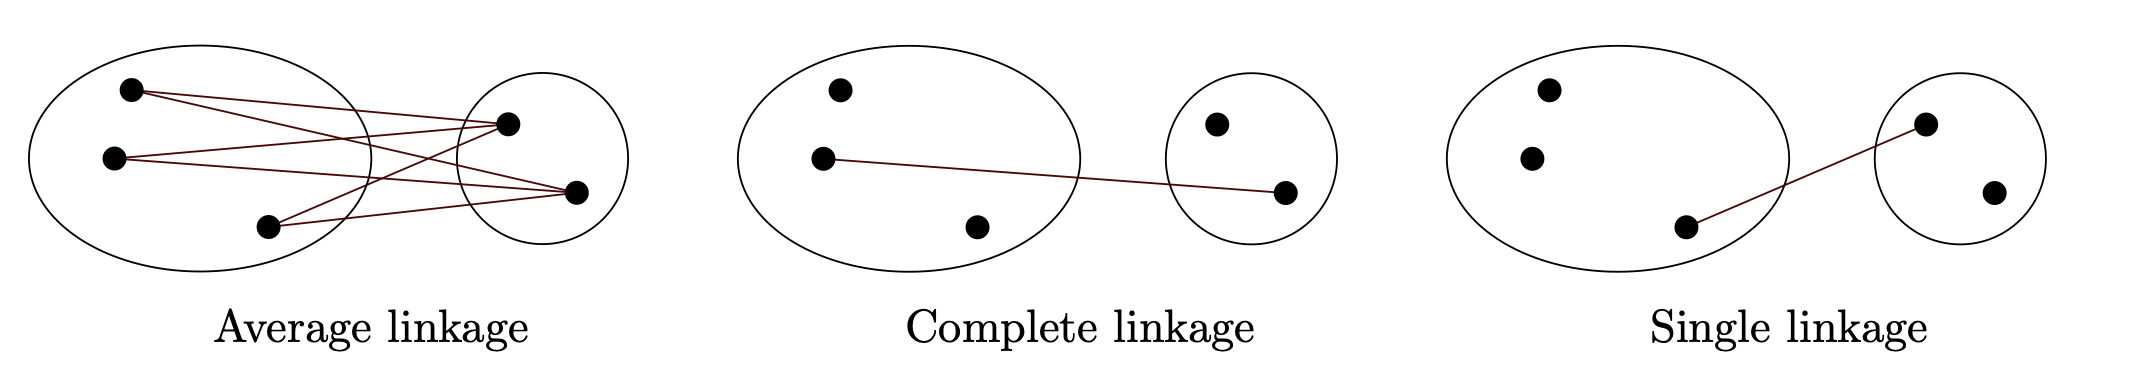

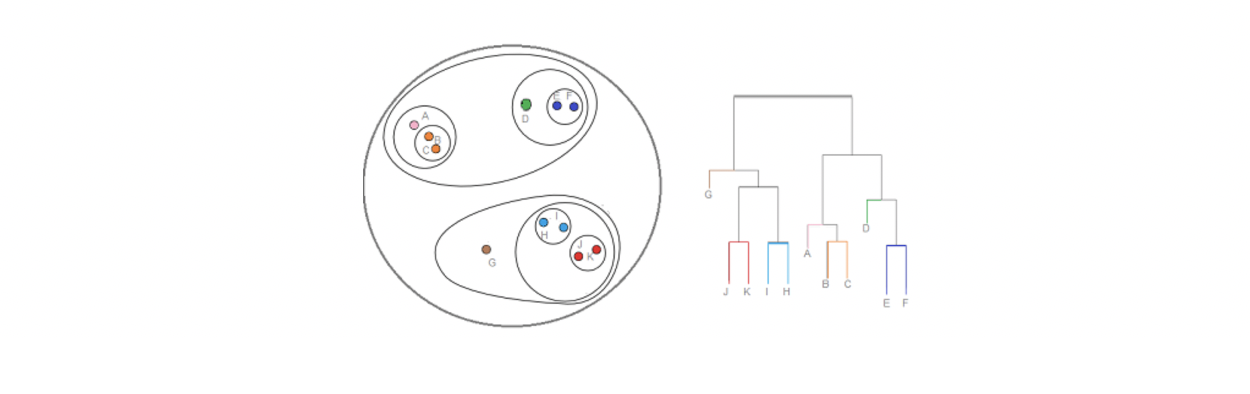

In [58]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

### Минимальное межкластерное расстояние ('single')

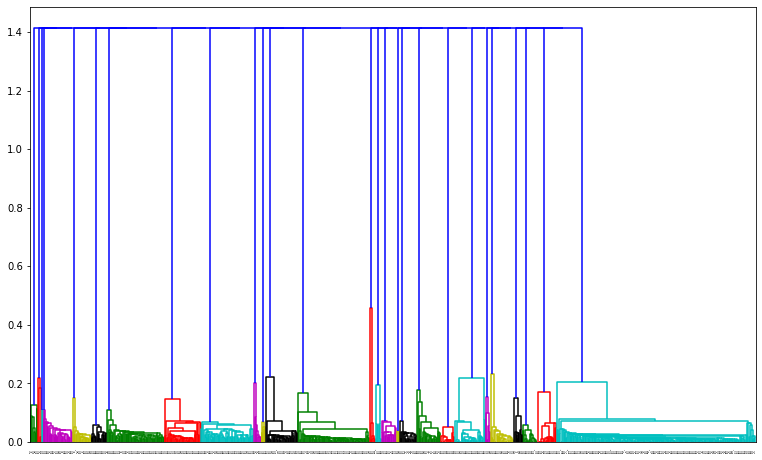

In [59]:
mergings1 = linkage(X_2.to_numpy(), method='single') # передаю сформированные признаки X_2

fig = plt.figure(figsize=(13, 8))
dendrogram(mergings1,leaf_font_size=2) # построение дендрограммы
plt.show()

In [60]:
label1 = fcluster(mergings1, 0.6, criterion='distance')
print("Кластеры: ", np.unique(label1))
print("Значение силуэта:", metrics.silhouette_score(X_2, label1))

Кластеры:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Значение силуэта: 0.9058305792698195


### Максимальное межкластерное расстояние ('complete')

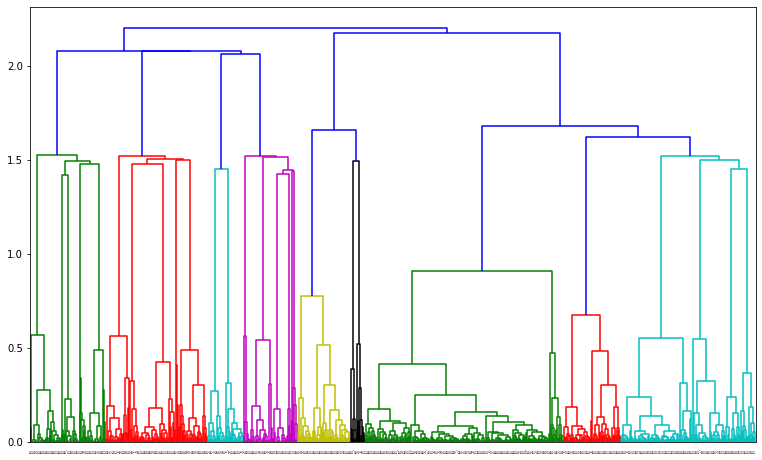

In [61]:
mergings2 = linkage(X_2.to_numpy(), method='complete') # передаю сформированные признаки X_2

fig = plt.figure(figsize=(13, 8))
dendrogram(mergings2, leaf_font_size=2) # построение дендрограммы
plt.show()

In [62]:
label2 = fcluster(mergings2, 1.6, criterion='distance')
print("Кластеры: ", np.unique(label2))
print("Значение силуэта:", metrics.silhouette_score(X_2, label2))

Кластеры:  [1 2 3 4 5 6 7 8 9]
Значение силуэта: 0.5730715865252841


### Метод невзвешенного попарного среднего ('average')

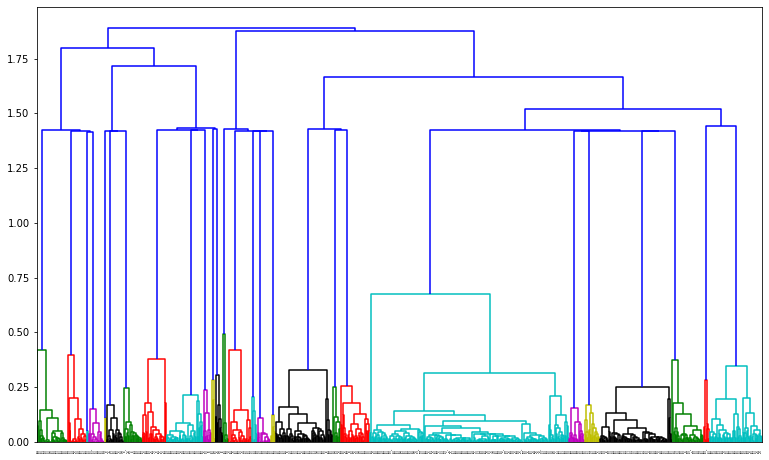

In [63]:
mergings3 = linkage(X_2.to_numpy(), method='average') # передаю сформированные признаки X_2

fig = plt.figure(figsize=(13, 8))
dendrogram(mergings3, leaf_font_size=2) # построение дендрограммы
plt.show()

In [64]:
label3 = fcluster(mergings3, 1.5, criterion='distance')
print("Кластеры: ", np.unique(label3))
print("Значение силуэта:", metrics.silhouette_score(X_2, label3))

Кластеры:  [1 2 3 4 5 6 7]
Значение силуэта: 0.43156726947380547


### Метод взвешенного попарного среднего ('weighted')

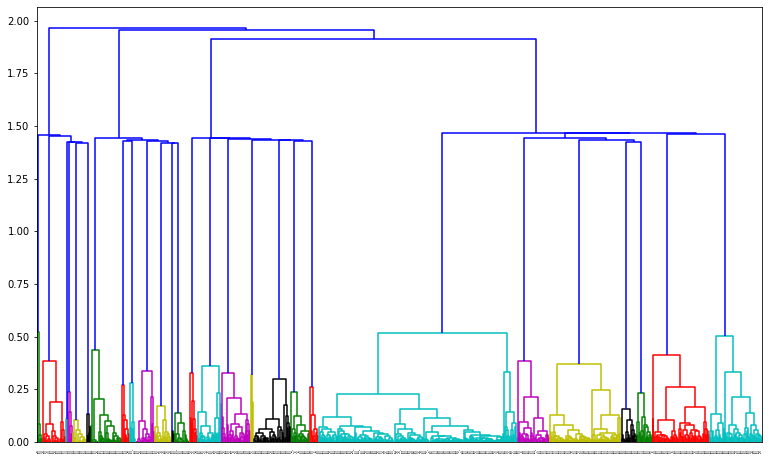

In [65]:
mergings4 = linkage(X_2.to_numpy(), method='weighted') # передаю сформированные признаки X_2

fig = plt.figure(figsize=(13, 8))
dendrogram(mergings4, leaf_font_size=2) # построение дендрограммы
plt.show()

In [66]:
label4 = fcluster(mergings4, 1.6, criterion='distance')
print("Кластеры:", np.unique(label4))
print("Значение силуэта:", metrics.silhouette_score(X_2, label4))

Кластеры: [1 2 3 4]
Значение силуэта: 0.395234980059095


Таким образом, используя разные методы рассчета расстояния между кластерами мы __построили несколько вариантов иерархической кластеризации и получили количества кластеров: 27, 9, 7, 4__. Количеству кластеров 27 соответствует наибольший коэффициент силуэта, однако остальные варианты разбиения на кластеры имеют право на существование. Попробуем оценить количество кластеров с помощью максимизации коэффициента силуэта, для этого воспользуемся алгоритмом K-Means. 

## 4.3 K-Means

Алгоритм __K-means__ представляет собой итеративный процесс. Пусть в начале произвольным образом выбраны центры классов. Объект относится к тому кластеру, расстояние до центра которого меньше. На каждой итерации сначала пересчитываются положения центра каждого класса как среднее арифметическое отнесенных к нему точек, а после этого объекты перераспределяются на основании новых положений центров.

In [67]:
from sklearn import datasets
from sklearn.cluster import KMeans

In [68]:
def kmeans_alg(X_df, n):
    """
    Input: X_df - признаковое описание объектов; 
           n - количество кластеров на выходе.
    Output: labels - метки классов, s - коэффициент силуэта
    """
    model = KMeans(n_clusters=n, init="k-means++") 
    model.fit(X_df)
    labels = model.predict(X_df)

    return labels, metrics.silhouette_score(X_df, labels)

In [69]:
labels_k, s_k = kmeans_alg(X_2, 9)
s_k # значение коэфиициента силуэта выше, чем в случае иерархической кластеризации при 9 кластерах

0.600473217028281

### Подбор количества кластеров с помошью максимизации силуэта + график силуэта

Найдем такой __параметр n - количество кластеров, который максимизирует коэффициент силуэта__. Построим __график силуэта__, который отображает меру того, насколько близко каждая точка в одном кластере находится к точкам в соседних кластерах, и, таким образом, обеспечивает способ визуальной оценки таких параметров, как количество кластеров.  

In [70]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [71]:
def show_cluster(X_df, range_n_clusters=[3, 4, 7, 9, 12, 15, 20, 25, 27, 28, 29, 30, 35]):
    
    """
    Input: X_df - признаковое описание объектов; 
           range_n_clusters - список с количествами кластеров для проверки.
    Output: значения коэффициентов силуэта, при каждом из range_n_clusters;
            график силуэта.
    """
    
    data = X_df.to_numpy()

    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([0, 0.6])
        ax1.set_ylim([0.6, len(data) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, random_state=10, init='k-means++')
        cluster_labels = clusterer.fit_predict(data)
        
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("Для количества кластеров", n_clusters,
              "Среднее значение коэффициента силуэта:", silhouette_avg)
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  

        ax1.set_title("Значение силуэта для различного количества кластеров")
        ax1.set_xlabel("Значение силуэта")
        ax1.set_ylabel("Метки кластеров")
        
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
        
        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')
        
        ax2.set_xlim([-0.01, 0.1])
        ax2.set_ylim([0, 0.06])
        ax2.set_title("Визуализация кластеров")
        ax2.set_xlabel("Первый признак")
        ax2.set_ylabel("Второй признак")

    plt.show()

Для количества кластеров 3 Среднее значение коэффициента силуэта: 0.34452073672141
Для количества кластеров 4 Среднее значение коэффициента силуэта: 0.4001816958674955
Для количества кластеров 7 Среднее значение коэффициента силуэта: 0.5561132111652226
Для количества кластеров 9 Среднее значение коэффициента силуэта: 0.6276175259738309
Для количества кластеров 12 Среднее значение коэффициента силуэта: 0.6999449990945427
Для количества кластеров 15 Среднее значение коэффициента силуэта: 0.7734085634495447
Для количества кластеров 20 Среднее значение коэффициента силуэта: 0.8543267445095742
Для количества кластеров 25 Среднее значение коэффициента силуэта: 0.8977683351609964
Для количества кластеров 27 Среднее значение коэффициента силуэта: 0.9058305792698195
Для количества кластеров 28 Среднее значение коэффициента силуэта: 0.8385537224010103
Для количества кластеров 29 Среднее значение коэффициента силуэта: 0.8230237487058835
Для количества кластеров 30 Среднее значение коэффициента си

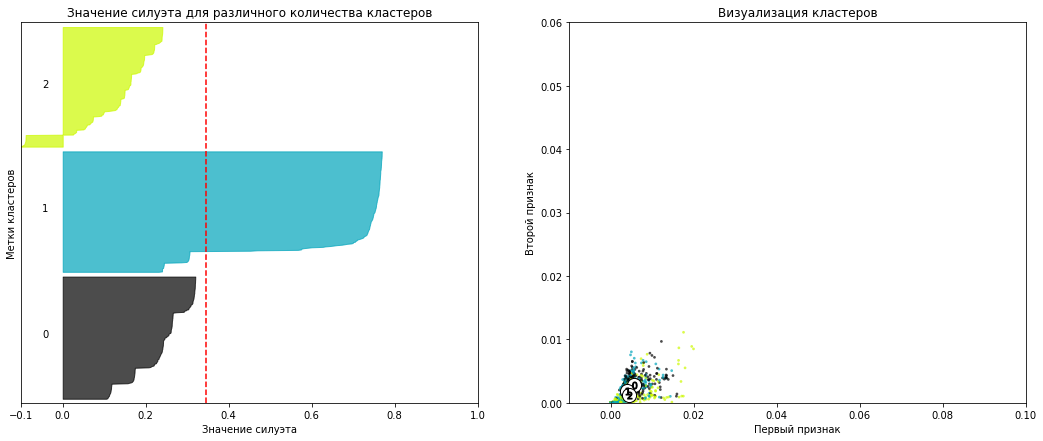

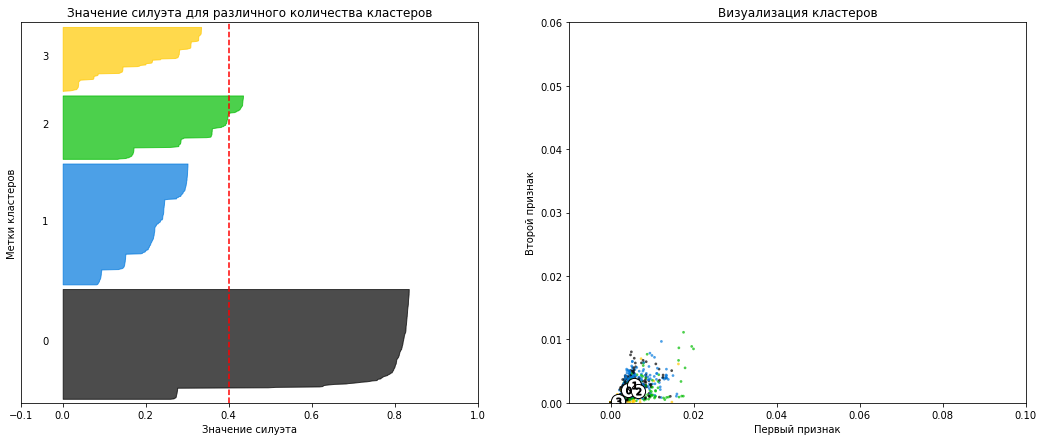

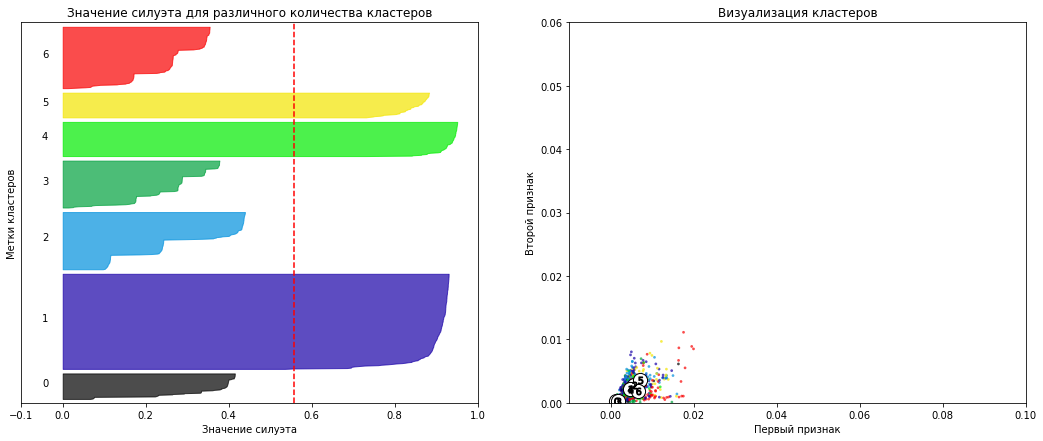

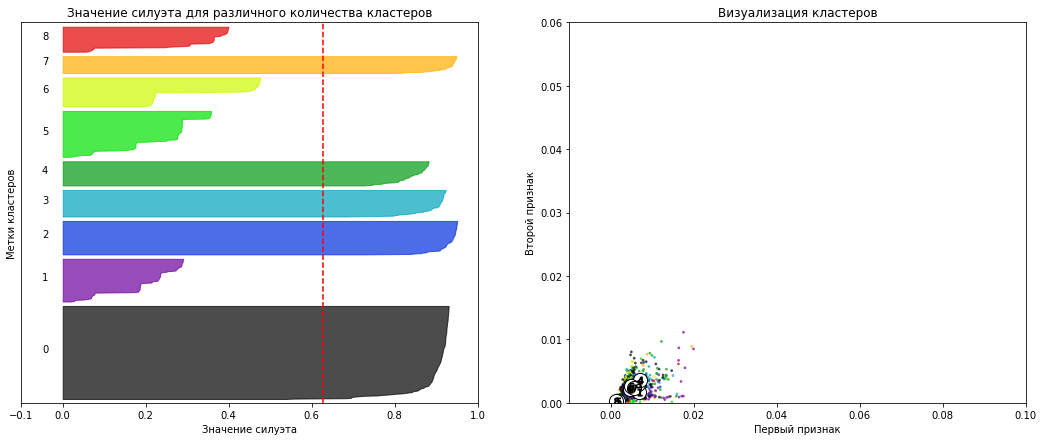

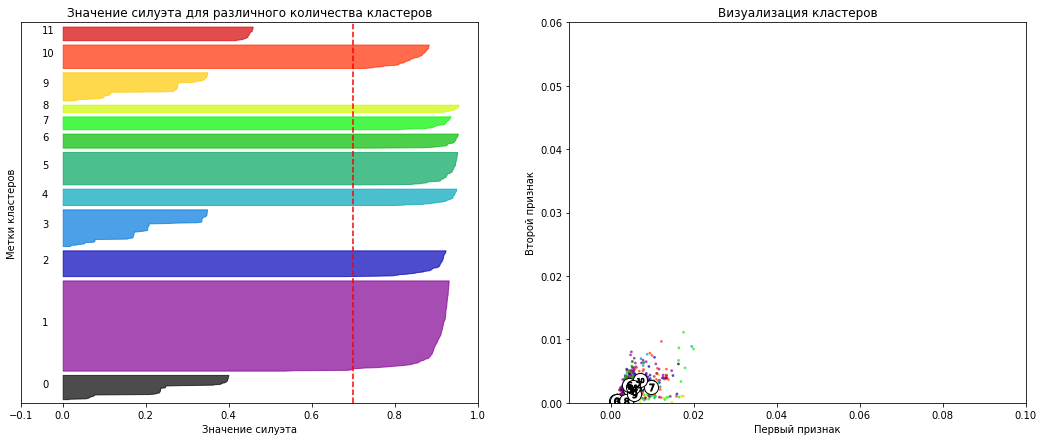

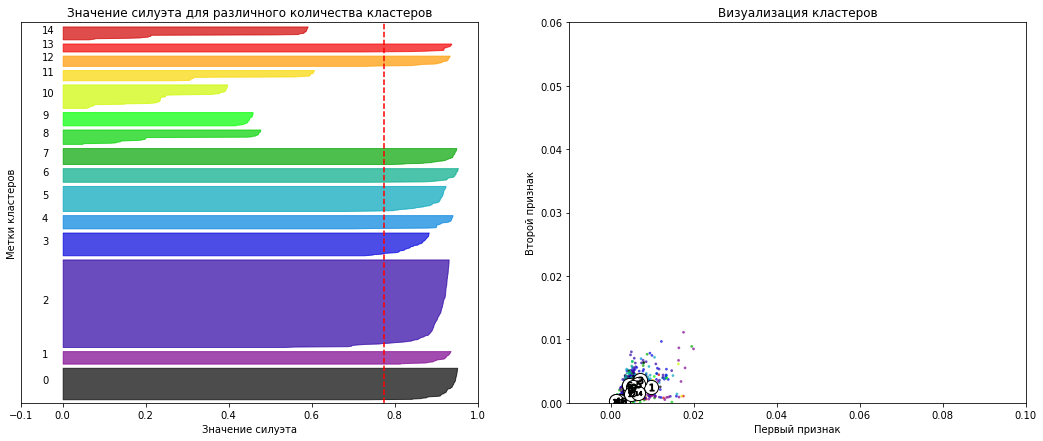

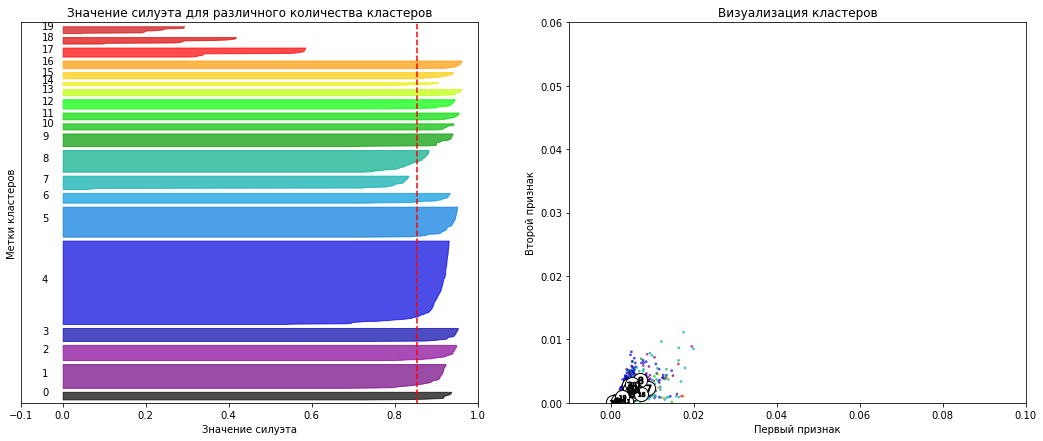

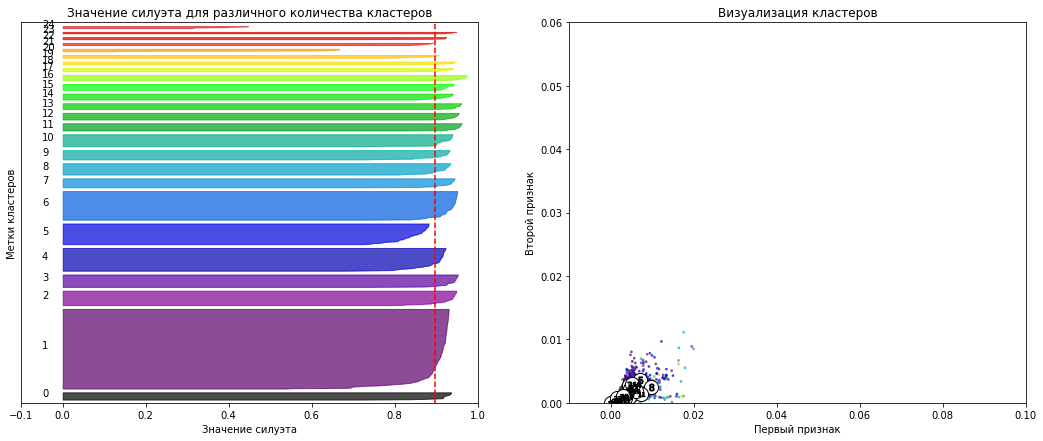

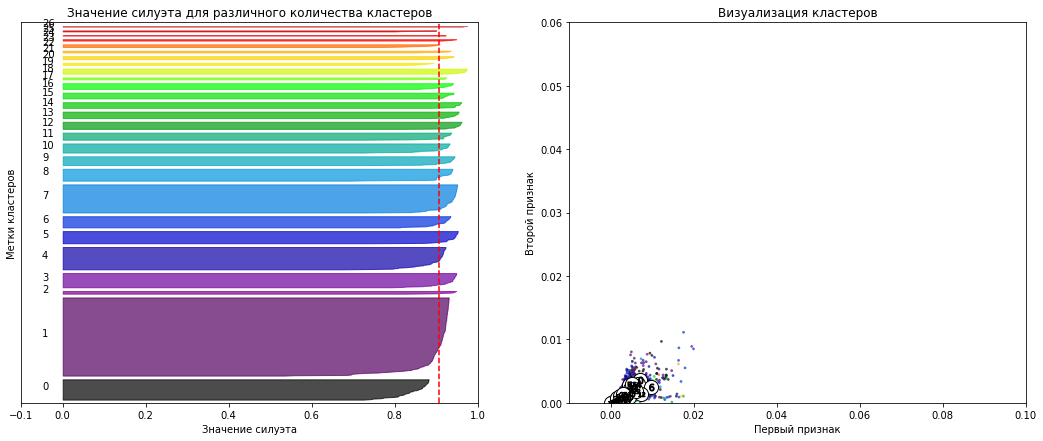

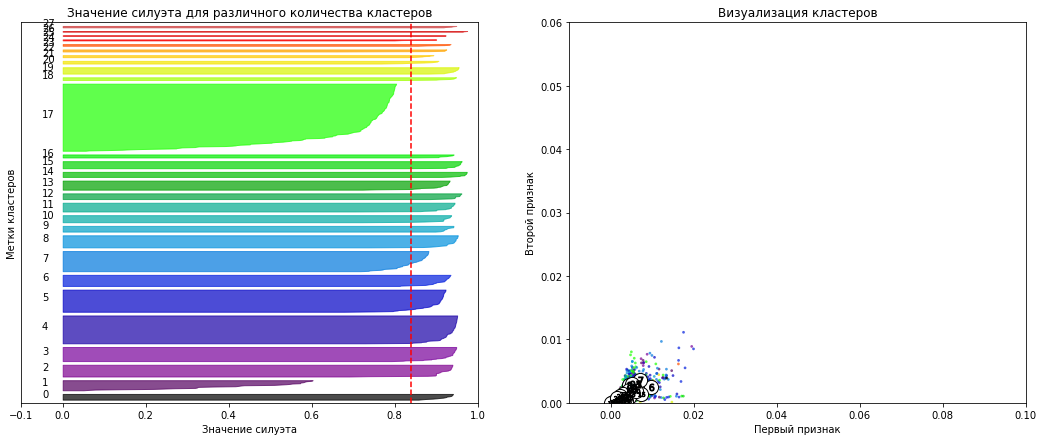

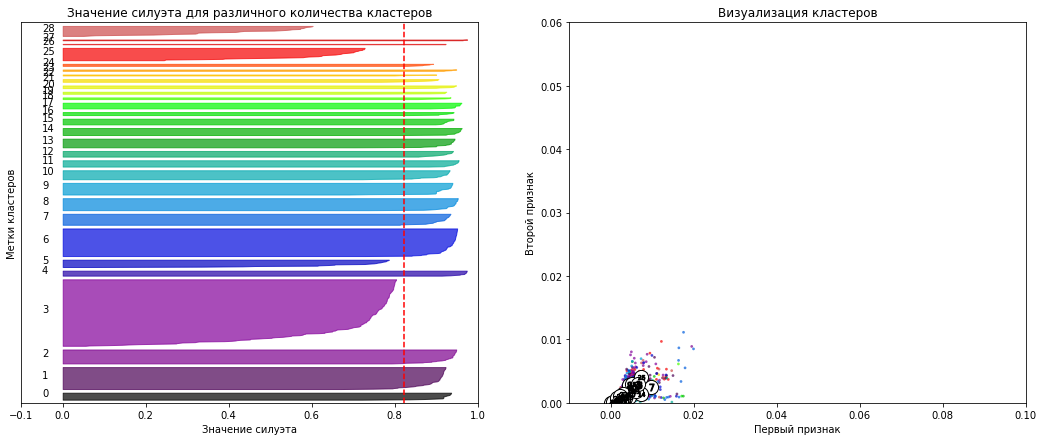

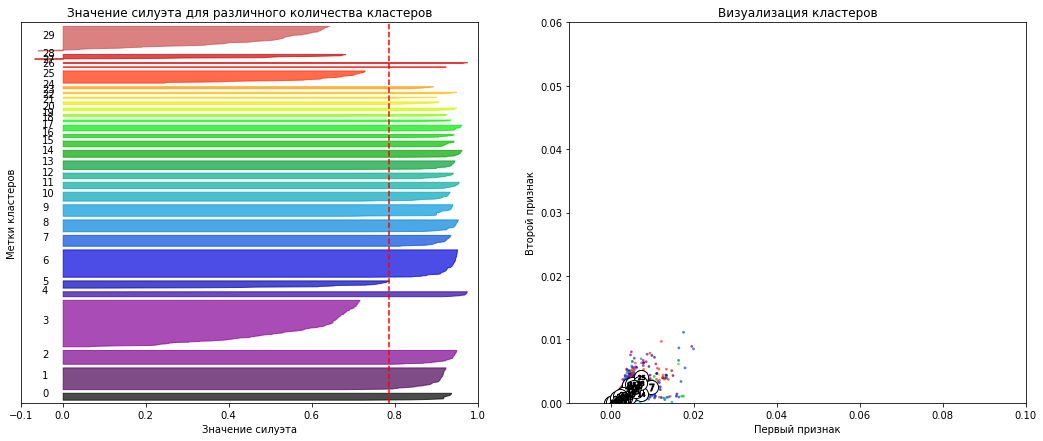

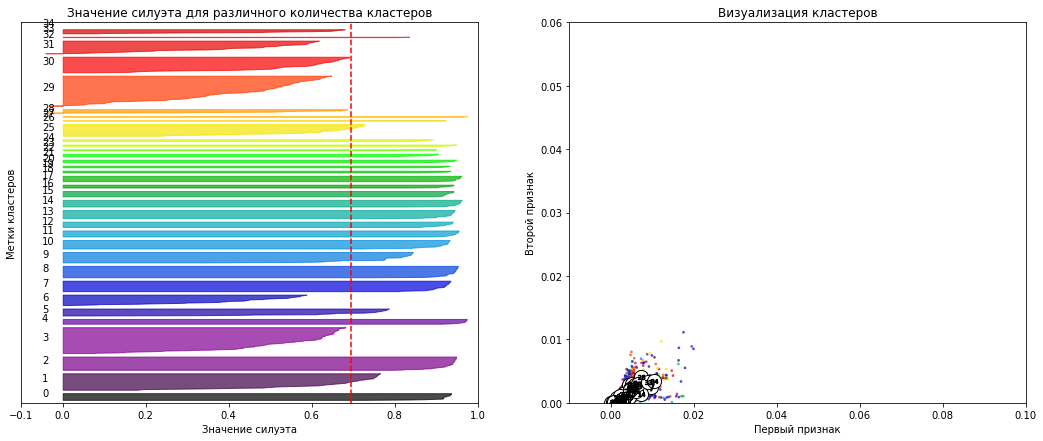

In [72]:
show_cluster(X_2)  
# на правых графиках представлена визуализация кластеров, однако она не слишком наглядно отображает реальную картину
# не всегда признаки можно корректно отобразить в двумерном признаковом пространстве (перейти от 21 признака к 2)

На правых графиках представлена визуализация кластеров, однако она не слишком наглядно отображает реальную картину. Не всегда признаки можно корректно отобразить в двумерном признаковом пространстве (перейти от 21 признака к 2).

Заметим, что максимум среднего значения коэффициента силуэта достигается при количестве кластеров равном 27. Действительно, в случае __27 кластеров__, значение силуэта каждого из кластеров примерно одинаковые, что говорит о том, что __кластеры хорошо сформированы__

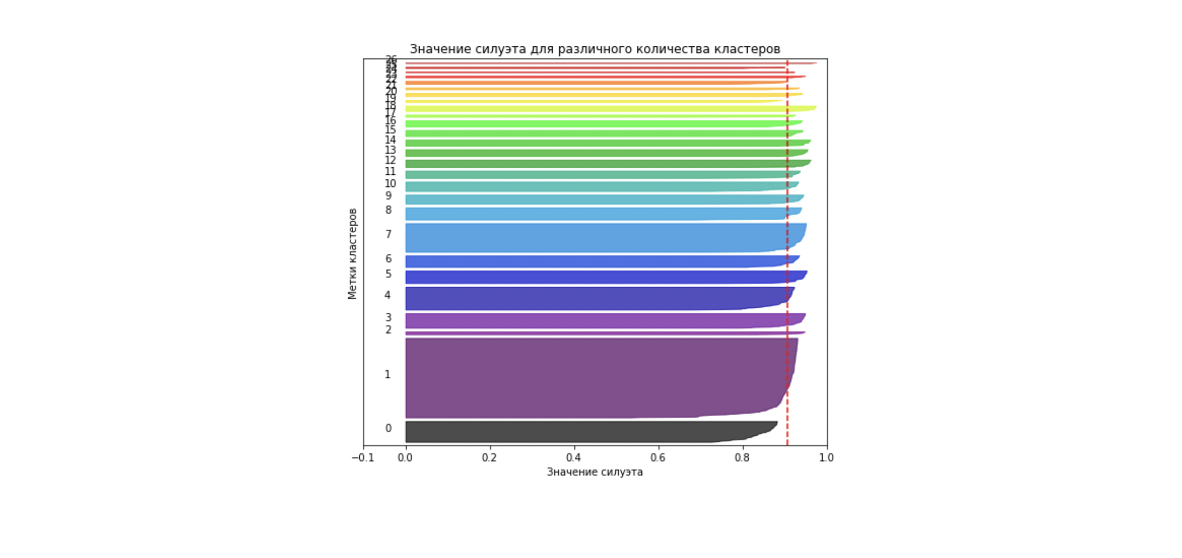

Однако интерпритировать такое количество кластеров (27) будет достаточно сложно, с учетом того что признаков у нас всего 21. __Попытаемся подобрать оптимальное число кластеров, так, чтобы коэффициент силуэта остался высоким и количество класеров было не большим__

## Подбор количества кластеров с помощью анализа скорости убывания расстояний между выделенными кластерами

In [73]:
import matplotlib.ticker as ticker

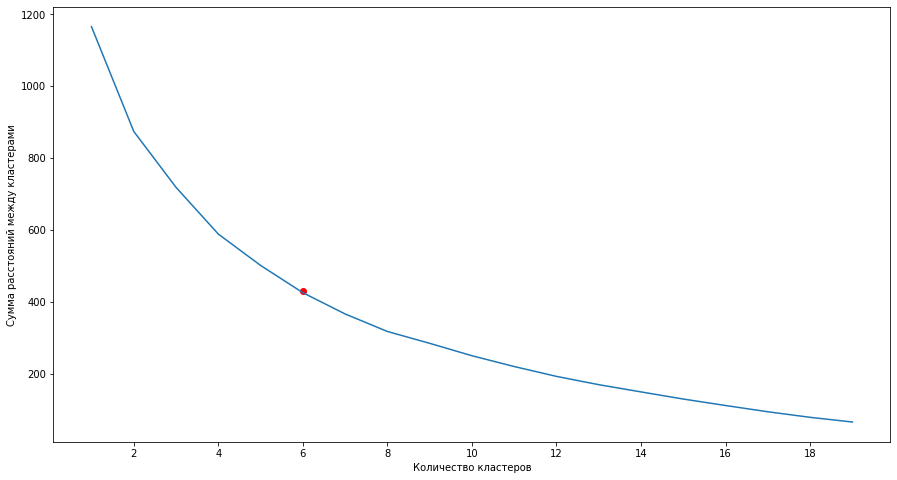

In [79]:
data = X_2.copy()

sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(data)
    data["clusters"] = kmeans.labels_ # получаем сумму расстояний
    sse[k] = kmeans.inertia_ 

fig, ax = plt.subplots(figsize=(15, 8))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.plot(list(sse.keys()), list(sse.values()))
ax.scatter(6, 430, c='r')
ax.set(xlabel='Количество кластеров', ylabel='Сумма расстояний между кластерами')
plt.show()

На графике видно, что примерно __с количества кластеров 6 сумма расстояний начинает убывать гораздо медленнее__, а значит разница между кластерами становится небольшой. Для __6 кластеров коэффициент силуэта достигает примерно 0.6__, что является достаточно хорошим результатом. Более того, интерпретировать это число кластеров будет гораздо проще. Остановимся на данном количестве кластеров.

In [80]:
cluster_analysis = X_2 
cluster_analysis['labels'], s = kmeans_alg(X_2, 6) # получаем метки кластеров при n=10
cluster_analysis = cluster_analysis.sort_values('labels') # сортируем по значениям меток
cluster_analysis.head(5)

,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,Модификации тачки,Оружие,...,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,labels
493,0.0,0.0,0.0,0.0,0.0,0.140497,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
750,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
438,0.0,0.0,0.0,0.0,0.0,0.133968,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
765,0.0,0.0,0.0,0.0,0.0,0.137661,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
443,0.0,0.0,0.0,0.0,0.0,0.252748,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [81]:
cluster_analysis['labels'].value_counts() # плотность кластеров

1    232
5    164
2    150
3    121
4    115
0     63
Name: labels, dtype: int64

 Получим информацию со средними значениями признаков по каждому кластеру и интерпретируем её:

In [82]:
res = cluster_analysis.groupby(['labels'], as_index=False).mean() 
col = ['Ядер-Кола', 'Медпрепараты и еда', 'Солярка', 'Патроны', 'Броня и одежда', 'Оружие', 'Модификации тачки', 'Съедобный хлам','Жидкости для тачки', 'Хлам']
res[col]= res[col]*100 # доля продаваемой продукции в процентах
res.to_csv('for_cluster_analysis.csv', index=True) 
res

,labels,Хлам,Броня и одежда,Медпрепараты и еда,Жидкости для тачки,Патроны,Солярка,Ядер-Кола,Съедобный хлам,Модификации тачки,...,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0,0.131206,0.035527,0.037692,0.020566,0.713840,14.813218,0.126730,0.270769,0.015661,...,0.079365,0.031746,0.111111,0.000000,0.253968,0.095238,0.0,0.0,0.0,1.0
1,1,0.469698,0.218853,0.584143,0.123849,2.774500,22.276000,1.171554,1.609764,0.124020,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0
2,2,0.652292,0.191887,0.529549,0.113355,4.061823,18.826412,1.330355,1.983730,0.097261,...,0.226667,0.146667,0.026667,0.060000,0.066667,0.286667,0.0,1.0,0.0,0.0
3,3,0.454256,0.233110,0.472477,0.134099,3.007676,17.424546,0.890693,1.269575,0.128019,...,0.000000,0.000000,0.000000,0.000000,0.305785,0.694215,1.0,0.0,0.0,0.0
4,4,0.189929,0.027244,0.018660,0.027595,0.735450,14.471360,0.072249,0.309644,0.009539,...,0.078261,0.173913,0.026087,0.060870,0.156522,0.313043,0.0,0.0,1.0,0.0
5,5,0.652429,0.309504,1.357392,0.197187,3.395721,37.234996,2.267433,2.780617,0.214690,...,0.408537,0.109756,0.109756,0.371951,0.000000,0.000000,1.0,0.0,0.0,0.0


# &5 Интерпритация результатов

Таким образом, полученную кластеризацию можно интерпретировать следующим образом: 

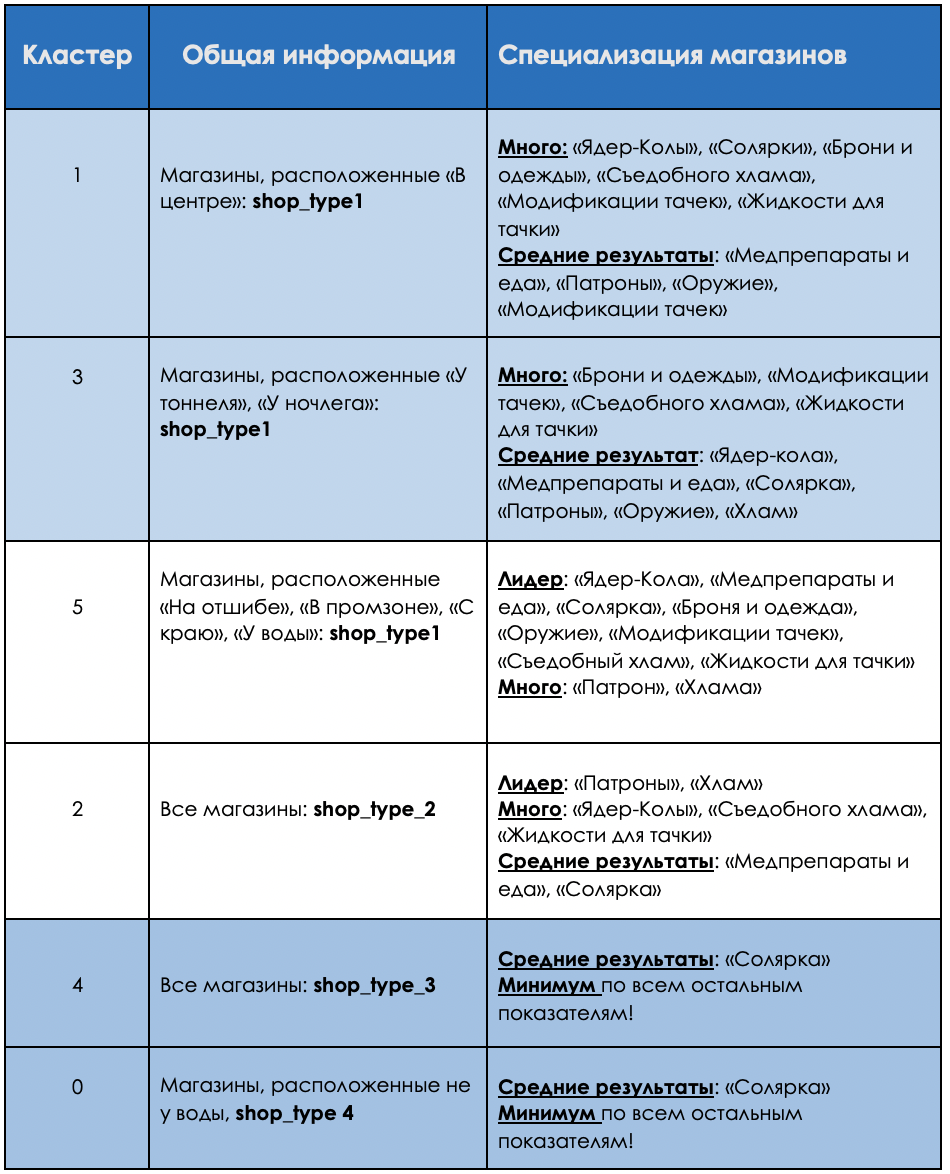

Запишем метки полученной кластеризации в файл __result__:

In [101]:
cluster_analysis.sort_index(inplace=True)
cluster_analysis['shop_id']= shop_id
cluster_analysis[['shop_id', 'labels']].to_csv('result.csv', sep='\t', index=False) 

## Чем полученная кластеризация лучше разбиения по горадам?

Разбиение по городам никак не учитывает профили продаж магазинов. С помощью полученной кластеризации можно понять, в каких магазинах, на продажу каких товаров стоит обратить внимание. Более того, с помощью полученнной кластеризации можно прогнозировать спрос на товары в магазинах. За счет качественного прогнозирования спроса на товар мы снижаем количество остатков в магазине, поставляем "популярные" товары в нужном количестве и не перегружаем автомобили доставки товара в магазин бесполезными товарами. Как результат, больше покупателей, больше продаем товара, меньше остатков, выше точность доставки, меньше затрат на логистику, увеличение прибыли. 


## Чтобы вы сделали, имея больше ресурсов/времени/данных (каких?)

Имея больше времени, я бы изучила, как можно было бы разбить магазины на большее количество кластеров (оптимальным было бы такое разбиение?), и попробовала бы интерпритировать результаты (так как именно качественная интерпритация требует достаточно много времени). 

Также я бы изучила и апробировала метод распространения близости (Affinity propagation) так как этот метод кластеризации довольно трудоемкий.